## TODO (Jake):
- Normalize data?
- Data augmentation (rotate, shear, zoom, ...)
- Try different activation functions (plot it and shit)

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a96f2c6b86d8106bfd31dfdbeb96e4879a6594ba1f6efdbb607574c2c81f0c89
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


## Imports

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import time

import medmnist
from medmnist import INFO, Evaluator

## Data Loading and Preprocessing

In [ ]:
import medmnist
from torchvision import transforms
import torch.utils.data as data
from torch.nn.functional import one_hot

data_flag = 'organamnist'  # set the name of the dataset to download
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Parameters
BATCH_SIZE = 128

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 matrix to a 784-dimensional vector
])

# apply one-hot encoding to labels
class OneHotEncodedDataset(DataClass):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        label = one_hot(torch.tensor(label), num_classes=n_classes).float()  # One-hot encode the label
        return image, label

# load the data with one-hot encoded labels
train_dataset = OneHotEncodedDataset(split='train', transform=data_transform, download=download)
test_dataset = OneHotEncodedDataset(split='test', transform=data_transform, download=download)
val_dataset = OneHotEncodedDataset(split="val", transform=data_transform, download=download)

train_dataset_size128 = OneHotEncodedDataset(split='train', transform=data_transform, download=download, size=128)
test_dataset_size128 = OneHotEncodedDataset(split='test', transform=data_transform, download=download, size=128)
val_dataset_size128 = OneHotEncodedDataset(split="val", transform=data_transform, download=download, size=128)

# Get dataloader
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_size128 = data.DataLoader(dataset=train_dataset_size128, batch_size=BATCH_SIZE, shuffle=True)
test_loader_size128 = data.DataLoader(dataset=test_dataset_size128, batch_size=BATCH_SIZE, shuffle=False)
val_loader_size128 = data.DataLoader(dataset=val_dataset_size128, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Using downloaded and verified file: /root/.medmnist/organamnist_128.npz


## Info on the dataframes

In [ ]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
print("===================")
print("===================")
print(train_dataset_size128)
print("===================")
print(val_dataset_size128)
print("===================")
print(test_dataset_size128)

Dataset OneHotEncodedDataset of size 28 (organamnist)
    Number of datapoints: 34561
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform 

## Visualize

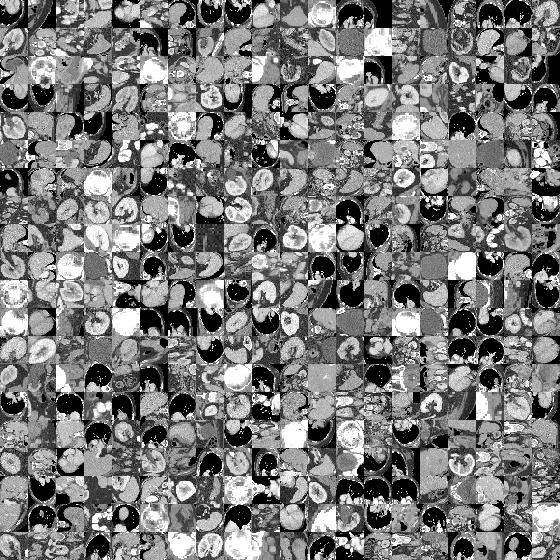

In [ ]:
train_dataset.montage(length=20)

In [ ]:
# print data shape
for inputs, targets in tqdm(train_loader):
      # forward + backward + optimize
      print(inputs.shape)
      print(targets.shape)
      break

  0%|          | 0/271 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 1, 11])


# Making a pandas data frame for the data

In [ ]:
import pandas as pd

# Store images and labels
data = []
labels = []

# Loop through a subset of the dataset or the entire dataset if desired
for images, lbls in train_loader:
    # Flatten each image and add it to the data list
    for img, lbl in zip(images, lbls):
        data.append(img.numpy())          # Convert image tensor to numpy array
        labels.append(lbl.argmax().item())  # Convert one-hot encoded label to class index

# Convert lists to DataFrame
df = pd.DataFrame(data)
df['label'] = labels  # Add labels as the last column

# Show the first few rows of the DataFrame
print(df.head())
print("===================")
print(len(df))

          0         1         2         3         4         5         6  \
0  0.200000  0.317647  0.184314  0.278431  0.247059  0.168628  0.419608   
1  0.003922 -0.215686  0.952941  0.145098  0.184314  0.200000  0.403922   
2 -1.000000 -1.000000 -1.000000 -1.000000  0.145098  0.058824 -1.000000   
3  0.396078  0.396078  0.090196  0.105882  0.105882  1.000000  1.000000   
4  0.176471 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   

          7         8         9  ...       775       776       777       778  \
0  0.333333 -0.145098  0.050980  ...  1.000000  1.000000  1.000000  1.000000   
1  0.239216  0.372549  0.223529  ... -0.474510  0.200000  0.207843 -0.239216   
2 -1.000000 -0.592157  0.254902  ... -1.000000 -1.000000 -1.000000 -1.000000   
3  1.000000  1.000000  1.000000  ...  0.168628 -0.058824 -0.058824 -0.003922   
4 -1.000000 -1.000000 -1.000000  ... -1.000000 -1.000000 -1.000000 -1.000000   

        779       780       781       782       783  label  
0  1.00

In [ ]:
import pandas as pd

def dataset_to_dataframe(data_loader):
    # Store images and labels
    data = []
    labels = []

    # Loop through the dataset
    for images, lbls in data_loader:
        # Flatten each image and add it to the data list
        for img, lbl in zip(images, lbls):
            data.append(img.numpy())           # Convert image tensor to numpy array
            labels.append(lbl.argmax().item())  # Convert one-hot encoded label to class index

    # Convert lists to DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels  # Add labels as the last column

    # Print the first few rows and the total number of data points
    # print("First few rows of the DataFrame:")
    # print(df.head())
    # print("===================")
    # print("Number of data points:", len(df))

    return df

# Making the dataframes with size 28
train_df = dataset_to_dataframe(train_loader)
val_df = dataset_to_dataframe(val_loader)
test_df = dataset_to_dataframe(test_loader)




## Improved converting to DF

In [ ]:
import torch
from medmnist import INFO
from medmnist.dataset import OrganAMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import pandas as pd
##################################
########### PARAMETERS ###########
##################################
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
IMSIZE = 128
##################################
##################################
##################################
device = torch.device("cpu")
data_flag = "organamnist"
info = INFO[data_flag]
n_classes = len(info["label"])

# Load dataset
transform = Compose([ToTensor(), Normalize(mean=[.5], std=[.5])])

train_data_size128 = OrganAMNIST(split="train", transform=transform, download=True, size=IMSIZE) # type <class 'medmnist.dataset.OrganAMNIST'>
val_data_size128 = OrganAMNIST(split="val", transform=transform, download=True, size=IMSIZE)
test_data_size128 = OrganAMNIST(split="test", transform=transform, download=True, size=IMSIZE)

# Function to convert a dataset to a pandas DataFrame
def dataset_to_dataframe(dataset):
    data = []
    for img, label in dataset:
        # Convert image tensor to a flattened list for DataFrame storage
        img_flat = img.numpy().flatten()
        data.append({"image": img_flat, "label": int(label)})
    return pd.DataFrame(data)

# Convert each dataset to a DataFrame
train_data_size128 = dataset_to_dataframe(train_data_size128)
val_data_size128 = dataset_to_dataframe(val_data_size128)
test_data_size128 = dataset_to_dataframe(test_data_size128)

# One-hot encode the labels
train_data_size128 = pd.concat([train_data_size128.drop(columns=["label"]),
                      pd.get_dummies(train_data_size128["label"], prefix="class")], axis=1)

val_data_size128 = pd.concat([val_data_size128.drop(columns=["label"]),
                    pd.get_dummies(val_data_size128["label"], prefix="class")], axis=1)

test_data_size128 = pd.concat([test_data_size128.drop(columns=["label"]),
                     pd.get_dummies(test_data_size128["label"], prefix="class")], axis=1)

# # Check the structure of the DataFrame
# print(train_data_size128.head())




100%|██████████| 708M/708M [00:55<00:00, 12.8MB/s]


Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Using downloaded and verified file: /root/.medmnist/organamnist_128.npz


<ipython-input-2-d2323cd8e57f>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.append({"image": img_flat, "label": int(label)})


In [ ]:
import numpy as np

def convert_dataframe_for_mlp(df):
    """
    Converts a DataFrame with image data and one-hot encoded labels into a format suitable for an MLP.

    Parameters:
    - df: DataFrame containing 'image' (flattened image arrays) and one-hot encoded class columns.

    Returns:
    - converted_df: DataFrame with image data split into individual columns and labels as integers.
    """
    # Split the 'image' column into individual pixel columns
    image_data = np.stack(df['image'].apply(lambda x: np.array(x)).values)
    image_df = pd.DataFrame(image_data, columns=[f"pixel_{i}" for i in range(image_data.shape[1])])

    # Extract the label by finding the one-hot column with `True` or `1`
    label_column = df.filter(like="class_").idxmax(axis=1).str.replace("class_", "").astype(int)

    # Combine image data with the labels
    converted_df = pd.concat([image_df, label_column.rename("label")], axis=1)

    return converted_df


In [ ]:
# Convert the train, validation, and test DataFrames
train_data_size128 = convert_dataframe_for_mlp(train_data_size128)
# val_data_size128 = convert_dataframe_for_mlp(val_data_size128)
# test_data_size128 = convert_dataframe_for_mlp(test_data_size128)


# Check the structure of the resulting DataFrame
print(train_data_size128.head())



    pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5   pixel_6  \
0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
1 -0.521569 -0.537255 -0.560784 -0.576471 -0.537255 -0.529412 -0.545098   
2  0.066667  0.066667  0.098039  0.168628  0.239216  0.309804  0.325490   
3 -0.435294 -0.458824 -0.435294 -0.301961 -0.333333 -0.262745 -0.113725   
4 -0.011765 -0.011765 -0.035294 -0.082353 -0.129412 -0.168627 -0.090196   

    pixel_7   pixel_8   pixel_9  ...  pixel_16375  pixel_16376  pixel_16377  \
0 -1.000000 -1.000000 -1.000000  ...     0.317647     0.011765    -0.145098   
1 -0.560784 -0.545098 -0.498039  ...    -1.000000    -1.000000    -1.000000   
2  0.294118  0.262745  0.231373  ...    -0.294118    -0.160784    -0.027451   
3 -0.027451  0.058824  0.105882  ...    -0.686275    -1.000000    -1.000000   
4  0.011765  0.113726  0.223529  ...     0.372549     0.411765     0.450980   

   pixel_16378  pixel_16379  pixel_16380  pixel_16381  pixel_16382  \
0   

17

In [ ]:
# Convert the train, validation, and test DataFrames
# train_data_size128 = convert_dataframe_for_mlp(train_data_size128)
val_data_size128 = convert_dataframe_for_mlp(val_data_size128)
# test_data_size128 = convert_dataframe_for_mlp(test_data_size128)


232

In [ ]:
# Convert the train, validation, and test DataFrames
# train_data_size128 = convert_dataframe_for_mlp(train_data_size128)
# val_data_size128 = convert_dataframe_for_mlp(val_data_size128)
test_data_size128 = convert_dataframe_for_mlp(test_data_size128)


453

## Data stats

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution_side_by_side(train_distribution, test_distribution):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    axes[0].bar(train_distribution.index, train_distribution.values, color='darkorange')
    axes[0].set_title("Train Dataset Label Distribution")
    axes[0].set_xlabel("Label")
    axes[0].set_ylabel("Count")
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)
    axes[0].set_xticks(train_distribution.index)

    axes[1].bar(test_distribution.index, test_distribution.values, color='skyblue')
    axes[1].set_title("Test Dataset Label Distribution")
    axes[1].set_xlabel("Label")
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)
    axes[1].set_xticks(test_distribution.index)

    plt.tight_layout()
    plt.show()

def analyze_class_distribution_side_by_side(train_distribution, test_distribution):
    train_percentages = (train_distribution / train_distribution.sum()) * 100
    test_percentages = (test_distribution / test_distribution.sum()) * 100

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].pie(
        train_percentages,
        labels=train_percentages.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab10.colors
    )
    axes[0].set_title("Train Dataset Class Distribution")

    axes[1].pie(
        test_percentages,
        labels=test_percentages.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab10.colors
    )
    axes[1].set_title("Test Dataset Class Distribution")

    plt.tight_layout()
    plt.show()

train_label_distribution = train_df['label'].value_counts().sort_index()
test_label_distribution = test_df['label'].value_counts().sort_index()

#plot_label_distribution_side_by_side(train_label_distribution, test_label_distribution)
#analyze_class_distribution_side_by_side(train_label_distribution, test_label_distribution)


def plot_label_correlation_heatmap(label_data, dataset_name="Combined"):
    correlation_matrix = label_data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        square=True
    )
    plt.title(f"{dataset_name} Dataset Label Correlation Heatmap")
    plt.tight_layout()
    plt.show()
#one_hot_labels = pd.get_dummies(train_df['label'], prefix='class')
#plot_label_correlation_heatmap(one_hot_labels, "Combined")

def plot_pixel_distribution(df, num_samples=1000):
    pixel_values = df.iloc[:, :-1].sample(num_samples, axis=0).values.flatten()
    plt.figure(figsize=(8, 6))
    sns.histplot(pixel_values, bins=50, kde=True, color='blue')
    plt.title(f"Pixel Value Distribution ({num_samples} Samples)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

#plot_pixel_distribution(train_df)

import seaborn as sns
import matplotlib.pyplot as plt

def pixel_variance_by_class(df):
    variances = df.groupby('label').apply(lambda x: x.iloc[:, :-1].var(axis=0).mean())
    plt.figure(figsize=(8, 6))
    sns.barplot(x=variances.index, y=variances.values, color='skyblue')
    plt.title("Average Pixel Variance Across Classes")
    plt.xlabel("Class")
    plt.ylabel("Pixel Variance")
    plt.show()

#pixel_variance_by_class(train_df)

# Task 2: Implement a Multilayer Perceprton

## Classes for every layer

In [ ]:
class ReLULayer:
    def __init__(self, in_size, out_size, lr, L1_reg = 0.0, L2_reg = 0.0):
        """
        Initialize a layer with ReLU activation.
        :param in_size: Size of input vector
        :param out_size: Size of output vector
        :param lr: Learning rate
        :param L1_reg: lambda for L1 regularization
        :param L2_reg: lambda for L2 regularization
        """
        self.in_size = in_size
        self.out_size = out_size
        self.lr = lr
        # input vector
        self.x = None
        # weights (in_size x out_size matrix)
        self.w = np.random.randn(in_size, out_size) / np.sqrt(in_size) # variance scaling
        # bias
        self.b = np.zeros(out_size)

        if L1_reg > 0.0 and L2_reg > 0.0:
            raise Exception("Only regularize on L1 or L2, not both. Set one of the terms to 0")

        self.L1_reg = L1_reg
        self.L2_reg = L2_reg

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def forward(self, x, is_train = True):
        # left multiply input vector by weight matrix, add bias vector
        z = np.dot(x, self.w) + self.b
        # apply ReLU activation to z
        self.a = self.relu(z)
        if is_train:
            self.x = x # Store input for backprop (needed for the derivative since it is either 0 or 1)
        return self.a

    def backward(self, dx):
        # Calculate the loss (the chain rule derivatives being propogated backwards in the NN) with respect to the activation function at this layer
        da = dx * self.relu_derivative(self.a) # element-wise multiplication of the derivative of the relu activation function
        dw = np.dot(self.x.T, da) # gradient of the loss with respect to the weight matrix
        db = np.sum(da, axis=0) # gradient of the loss with respect to the bias, which act independently so we sum them up

        # Apply L1 and L2 regularization to gradients
        if self.L1_reg > 0:
            dw += self.L1_reg * np.sign(self.w)  # L1 regularization term
        if self.L2_reg > 0:
            dw += self.L2_reg * 2 * self.w  # L2 regularization term

        # Update weights and biases
        self.w -= self.lr * dw
        self.b -= self.lr * db

        # Return the gradient of the loss with respect to the input
        return np.dot(da, self.w.T)


In [ ]:
class LeakyReLULayer:
    def __init__(self, in_size, out_size, lr, alpha=0.01, L1_reg = 0.0, L2_reg = 0.0):
        """
        Initialize a layer with Leaky ReLU activation.
        :param in_size: Size of input vector
        :param out_size: Size of output vector
        :param lr: Learning rate
        :param alpha: Slope of Leaky ReLU for negative inputs
        :param L1_reg: lambda for L1 regularization
        :param L2_reg: lambda for L2 regularization
        """
        self.in_size = in_size
        self.out_size = out_size
        self.lr = lr
        self.alpha = alpha  # Leaky ReLU slope for negative inputs
        self.x = None  # To store input for backpropagation

        # Initialize weights and biases
        self.w = np.random.randn(in_size, out_size) / np.sqrt(in_size)
        self.b = np.zeros(out_size)

        if L1_reg > 0.0 and L2_reg > 0.0:
            raise Exception("Only regularize on L1 or L2, not both. Set one of the terms to 0")

        self.L1_reg = L1_reg
        self.L2_reg = L2_reg

    def leaky_relu(self, x):
        return np.where(x > 0, x, self.alpha * x)

    def leaky_relu_derivative(self, x):
        return np.where(x > 0, 1, self.alpha)

    def forward(self, x, is_train=True):
        # Compute z = xW + b
        z = np.dot(x, self.w) + self.b
        # Apply Leaky ReLU activation
        self.a = self.leaky_relu(z)
        if is_train:
            self.x = x  # Store input for backpropagation
        return self.a

    def backward(self, dx):
        """
        Backward pass for the layer.
        :param dx: Gradient of the loss with respect to the layer output
        """
        # Compute gradient of loss w.r.t activation
        da = dx * self.leaky_relu_derivative(self.a)
        # Compute gradient of loss w.r.t weights and biases
        dw = np.dot(self.x.T, da)
        db = np.sum(da, axis=0)

        # Apply L1 and L2 regularization to gradients
        if self.L1_reg > 0:
            dw += self.L1_reg * np.sign(self.w)  # L1 regularization term
        if self.L2_reg > 0:
            dw += self.L2_reg * 2 * self.w  # L2 regularization term

        # Update weights and biases
        self.w -= self.lr * dw
        self.b -= self.lr * db

        # Return gradient of loss w.r.t input
        return np.dot(da, self.w.T)

In [ ]:
class SigmoidLayer:
  # TODO: check initialization of weights and bias
    def __init__(self, in_size, out_size, lr, L1_reg = 0.0, L2_reg = 0.0):
        """
        Initialize a layer with sigmoid activation.
        :param in_size: Size of input vector
        :param out_size: Size of output vector
        :param lr: Learning rate
        :param L1_reg: lambda for L1 regularization
        :param L2_reg: lambda for L2 regularization
        """
        self.in_size = in_size
        self.out_size = out_size
        self.lr = lr
        # input vector
        self.x = None
        # weights (in_size*out_size matrix)
        self.w = np.random.randn(in_size, out_size) / np.sqrt(in_size) # check to see what this does
        # bias
        self.b = np.zeros(out_size)

        if L1_reg > 0.0 and L2_reg > 0.0:
            raise Exception("Only regularize on L1 or L2, not both. Set one of the terms to 0")

        self.L1_reg = L1_reg
        self.L2_reg = L2_reg

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def forward(self, x, is_train=True):
        # left multiply input vector by weight matrix, add bias vector.
        z = np.dot(x, self.w) + self.b
        # Sigmoid activation applied to z
        self.a = self.sigmoid(z)
        if is_train:
            self.x = x  # Store input for backpropagation
        return self.a

    def backward(self, dx):
        # Calculate derivative of the loss with respect to the activation
        da = dx * self.sigmoid_derivative(self.a)  # Element-wise multiply by sigmoid derivative
        dw = np.dot(self.x.T, da)
        db = np.sum(da, axis=0)

         # Apply L1 and L2 regularization to gradients
        if self.L1_reg > 0:
            dw += self.L1_reg * np.sign(self.w)  # L1 regularization term
        if self.L2_reg > 0:
            dw += self.L2_reg * 2 * self.w  # L2 regularization term

        # Update weights and biases
        self.w -= self.lr * dw
        self.b -= self.lr * db

        # Return the gradient of the loss with respect to the input
        return np.dot(da, self.w.T)

In [ ]:
class TanhLayer:
    def __init__(self, in_size, out_size, lr, L1_reg = 0.0, L2_reg = 0.0):
        """
        Initialize a layer with Hyperbolic tangent activation.
        :param in_size: Size of input vector
        :param out_size: Size of output vector
        :param lr: Learning rate
        :param L1_reg: lambda for L1 regularization
        :param L2_reg: lambda for L2 regularization
        """
        self.in_size = in_size
        self.out_size = out_size
        self.lr = lr
        # input vector
        self.x = None
        # weights (in_size x out_size matrix)
        self.w = np.random.randn(in_size, out_size) / np.sqrt(in_size) # setting initial weights
        # bias
        self.b = np.zeros(out_size)

        if L1_reg > 0.0 and L2_reg > 0.0:
            raise Exception("Only regularize on L1 or L2, not both. Set one of the terms to 0")

        self.L1_reg = L1_reg
        self.L2_reg = L2_reg

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - (x) ** 2

    def forward(self, x, is_train = True):
        # left multiply input vector by weight matrix, add bias vector
        z = np.dot(x, self.w) + self.b
        # apply tanh activation to z
        self.a = self.tanh(z)
        if is_train:
            self.x = x # Store input for backpropogation
        return self.a

    def backward(self, dx):
        # Calculate the loss (the chain rule derivatives being propogated backwards in the NN) with respect to the activation function at this layer
        da = dx * self.tanh_derivative(self.a) # element-wise multiplication of the derivative of the tanh activation function
        dw = np.dot(self.x.T, da) # gradient of the loss with respect to the weight matrix
        db = np.sum(da, axis=0) # gradient of the loss with respect to the bias, which act independently so we sum them up

        # Apply L1 and L2 regularization to gradients
        if self.L1_reg > 0:
            dw += self.L1_reg * np.sign(self.w)  # L1 regularization term
        if self.L2_reg > 0:
            dw += self.L2_reg * 2 * self.w  # L2 regularization term

        # Update weights and biases
        self.w -= self.lr * dw
        self.b -= self.lr * db

        # Return the gradient of the loss with respect to the input
        return np.dot(da, self.w.T)


In [ ]:
class IdentityLayer:
    def __init__(self, input_size, output_size, lr = 0.01, L1_reg = 0.0, L2_reg = 0.0):
        """
        Initialize a layer with no activation.
        :param in_size: Size of input vector
        :param out_size: Size of output vector
        :param lr: Learning rate
        :param L1_reg: lambda for L1 regularization
        :param L2_reg: lambda for L2 regularization
        """
        self.input_size = input_size
        self.output_size = output_size
        self.lr = lr
        self.w = np.random.randn(input_size, output_size) / np.sqrt(input_size) # initializing weights
        self.b = np.zeros(output_size) # initializing bias

        self.x = None

        if L1_reg > 0.0 and L2_reg > 0.0:
            raise Exception("Only regularize on L1 or L2, not both. Set one of the terms to 0")
        self.L1_reg = L1_reg
        self.L2_reg = L2_reg

    def forward(self, x, is_train=True):
        if is_train:
            self.x = x
        return np.dot(x, self.w) + self.b

    def backward(self, dx):
        self.dw = np.dot(self.x.T, dx) + self.L1_reg * np.sign(self.w) + 2 * self.L2_reg * self.w
        self.db = np.sum(dx, axis = 0)

        self.w -= self.lr * self.dw
        self.b -= self.lr * self.db

        return np.dot(dx, self.w.T)


In [ ]:
class SoftmaxLayer:
    def __init__(self, input_size, output_size):
        """
        Initialize a Softmax Layer.

        Parameters:
        - input_size: The size of the input vector.
        - output_size: The size of the output vector (number of classes).
        """
        self.x = None  # Store the input to the layer (needed for backprop)
        self.dx = np.zeros((input_size, output_size))  # Gradient placeholder
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, x, is_train=True):
        """
        Forward pass through the softmax layer.

        Parameters:
        - x: Input matrix of shape (batch_size, input_size).
        - is_train: Whether this is a training step (stores input for backprop if True).

        Returns:
        - Output probabilities after applying the softmax function, shape (batch_size, output_size).
        """
        # Numerical stability: shift inputs by the max value for each batch element
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_shifted)
        exp_sum = np.sum(exp_x, axis=1, keepdims=True)
        softmax_output = exp_x / exp_sum

        if is_train:
            self.x = softmax_output  # Save the softmax probabilities for backprop
        return softmax_output

    def backward(self, y):
        """
        Backward pass for the softmax layer with cross-entropy loss.

        Parameters:
        - y: One-hot encoded labels, shape (batch_size, output_size).

        Returns:
        - Gradient of the loss with respect to the input, shape (batch_size, input_size).
        """
        # Compute the gradient: softmax output - true labels
        self.dx = self.x - y
        return self.dx


In [ ]:
class CategoricalCrossEntropy:
    def forward(self, y_hat, y):
        """
        Computes the categorical cross-entropy loss.

        Parameters:
        - y_hat: numpy array of predicted probabilities (output of softmax), shape (batch_size, num_classes)
        - y: numpy array of true labels (one-hot encoded), shape (batch_size, num_classes)

        Returns:
        - loss: scalar, average cross-entropy loss over the batch
        """
        # Clip predictions to prevent log(0), which leads to NaN
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)

        # Compute cross-entropy loss for each sample in the batch
        loss_sum = -np.sum(y * np.log(y_hat))  # Element-wise product and sum

        # Average the loss across the batch
        return loss_sum / y_hat.shape[0]

    def backward(self, y_hat, y):
        return y_hat - y

    # def save_parameters(self, params):
    #     param_dict = {}
    #     param_dict["layer"] = "CategoricalCrossEntropy"
    #     params.append(param_dict)
    #     return params


# MLP Class with returning arrays

In [ ]:
class MLP():
    def __init__(self, train_df, test_df, num_layers=2, layers=[64, 64], loss_function="softmax",
                 activation_func=["sigmoid", "relu"], batch_size=50, learning_rate=0.1, L1_reg = 0.0, L2_reg = 0.0,
                 max_iters=1000, epsilon=0.001):
        self.train_df = train_df
        self.test_df = test_df
        self.num_layers = num_layers
        self.layers = layers
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.output_size = 11
        self.max_iters = max_iters
        self.epsilon = epsilon

        if L1_reg > 0.0 and L2_reg > 0.0:
            raise Exception("Only regularize on L1 or L2, not both. Set one of the terms to 0")

        self.L1_reg = L1_reg
        self.L2_reg = L2_reg

        # Check if the number of activations matches the number of layers
        if len(activation_func) != num_layers:
            raise Exception("The number of activation functions must match the number of layers.")

        # Check to see if we have the no hidden layer case
        if num_layers == 0 and len(activation_func) == 0 and len(layers) == 0:
            activation_func = ["identity"]

        # Dictionary to map activation function names to their implementations
        activation_map = {
            "relu": ReLULayer,
            "leakyrelu": LeakyReLULayer,
            "sigmoid": SigmoidLayer,
            "tanh": TanhLayer,
            "identity": IdentityLayer
        }

        # Create an array of activation layers in the specified order
        self.activation_arr = []
        for i in range(len(activation_func)):
            if activation_func[i] in activation_map:
                layer_input_size = layers[i - 1] if i > 0 else train_df.shape[1] - 1 # Input size of this layer
                if i < num_layers - 1:
                    layer_output_size = layers[i]  # Output size of this layer
                else:
                    layer_output_size = self.output_size # Output size of the last layer is fixed to the number of classes
                self.activation_arr.append(activation_map[activation_func[i]](layer_input_size, layer_output_size, self.learning_rate, self.L1_reg, self.L2_reg))
            else:
                raise ValueError(f"Unsupported activation function: {activation_func[i]}")

        # Initialize the loss function
        if loss_function == "softmax":
            self.loss_layer = SoftmaxLayer(self.output_size, self.output_size)
            self.loss_fn = CategoricalCrossEntropy()
        else:
            raise ValueError(f"Unsupported loss function: {loss_function}")

    def softmax(self, x):
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_shifted)
        exp_sum = np.sum(exp_x, axis=1, keepdims=True)
        softmax_output = exp_x / exp_sum
        return softmax_output

    def forward(self, x, is_train=True):
        """
        Perform forward propagation through all layers.
        """
        for layer in self.activation_arr:
            x = layer.forward(x, is_train)
        # return x
        return self.softmax(x)

    def backward(self, predictions, labels):
        """
        Perform backpropagation through all layers.
        """
        loss_grad = self.loss_fn.backward(predictions, labels)  # Loss gradient
        # should do backward on softmax too
        for layer in reversed(self.activation_arr):
            loss_grad = layer.backward(loss_grad)
        return loss_grad # partial L / partial X, grad w.r.t. input data



    def fit(self, X, y, X_val=None, y_val=None, y_test=None, y_val_onehot = None, y_test_onehot=None, epochs=10):
        """
        Train the model with mini-batch gradient descent for a specified number of epochs.

        Parameters:
        - X: Training features.
        - y: One-hot encoded training labels.
        - X_val: Validation features (optional).
        - y_val: Validation labels (optional).
        - y_test: Test labels (optional).
        - y_test_onehot: One-hot encoded test labels (optional).
        - epochs: Number of epochs to train.

        Returns:
        - epoch_array: Array of epoch numbers.
        - train_losses: Array of training losses for each epoch.
        - val_losses: Array of validation losses for each epoch (if validation data is provided).
        - test_losses: Array of test losses for each epoch (if test data is provided).
        - train_accuracies: Array of training accuracies for each epoch.
        - val_accuracies: Array of validation accuracies for each epoch (if validation data is provided).
        - test_accuracies: Array of test accuracies for each epoch (if test data is provided).
        """
        N = X.shape[0]

        # Initialize arrays to store results
        epoch_array = []
        train_losses = []
        val_losses = []
        test_losses = []
        train_accuracies = []
        val_accuracies = []
        test_accuracies = []

        for epoch in range(epochs):
            # Shuffle the training data at the start of each epoch
            indices = np.arange(N)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # Mini-batch gradient descent
            for start in range(0, N, self.batch_size):
                end = start + self.batch_size
                batch_X = X[start:end]
                batch_y = y[start:end]

                # Forward and backward pass
                yhat = self.forward(batch_X)
                self.backward(yhat, batch_y)

            # Calculate train loss and accuracy
            train_predictions = self.forward(X)
            base_loss = -np.sum(y * np.log(train_predictions + self.epsilon)) / y.shape[0]
            train_loss = base_loss
            if self.L1_reg > 0:
                l1_loss = self.L1_reg * sum(np.sum(np.abs(layer.weights)) for layer in self.activation_arr if hasattr(layer, 'weights'))
                train_loss += l1_loss
            if self.L2_reg > 0:
                l2_loss = self.L2_reg * sum(np.sum(layer.weights ** 2) for layer in self.activation_arr if hasattr(layer, 'weights'))
                train_loss += l2_loss
            train_accuracy = self.eval_acc(np.argmax(y, axis=1), train_predictions)

            # Append train results
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validation loss and accuracy
            if X_val is not None and y_val is not None:
                val_predictions = self.forward(X_val)
                val_loss = -np.sum(y_val_onehot * np.log(val_predictions + self.epsilon)) / y_val_onehot.shape[0]
                if self.L1_reg > 0:
                    val_loss += l1_loss
                if self.L2_reg > 0:
                    val_loss += l2_loss
                val_accuracy = self.eval_acc(y_val, val_predictions)

                # Append validation results
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)
            else:
                val_losses.append(None)
                val_accuracies.append(None)

            # Test loss and accuracy
            if y_test_onehot is not None:
                test_predictions = self.forward(X_test)
                test_loss = -np.sum(y_test_onehot * np.log(test_predictions + self.epsilon)) / y_test_onehot.shape[0]
                if self.L1_reg > 0:
                    test_loss += l1_loss
                if self.L2_reg > 0:
                    test_loss += l2_loss
                test_accuracy = self.eval_acc(y_test, test_predictions)

                # Append test results
                test_losses.append(test_loss)
                test_accuracies.append(test_accuracy)
            else:
                test_losses.append(None)
                test_accuracies.append(None)

            # Store epoch
            epoch_array.append(epoch + 1)

            # Print progress
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%", end="")
            if X_val is not None:
                print(f", Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%", end="")
            if y_test_onehot is not None:
                print(f", Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%", end="")
            print()

        return epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies


    def predict(self, X):
      return self.forward(X)

    def eval_acc(self, y, haty):
        if len(haty.shape) > 1:
            predicted_labels = np.argmax(haty, axis=1)
        else:
            predicted_labels = haty

        accuracy = np.mean(predicted_labels == y)
        return accuracy

# The final Results

## plotting function

In [ ]:
import matplotlib.pyplot as plt


def plotting_stuff(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc):
    # Create the figure and axes for the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    epochs = list(range(1, 21))
    # Plot Train Loss, Validation Loss, and Test Loss vs Epochs
    ax1.plot(epochs, train_loss, label='Train Loss', color='blue', marker='o')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='green', marker='o')
    ax1.plot(epochs, test_loss, label='Test Loss', color='orange', marker='o')
    ax1.set_title('Loss vs Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot Train Accuracy, Validation Accuracy, and Test Accuracy vs Epochs
    ax2.plot(epochs, train_acc, label='Train Accuracy', color='blue', marker='o')
    ax2.plot(epochs, val_acc, label='Validation Accuracy', color='green', marker='o')
    ax2.plot(epochs, test_acc, label='Test Accuracy', color='orange', marker='o')
    ax2.set_title('Accuracy vs Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


## No hidden layer

Training the MLP model with epochs...
Epoch 1/20 - Train Loss: 0.9336, Train Accuracy: 70.61%, Validation Loss: 0.6298, Validation Accuracy: 83.69%, Test Loss: 1.2018, Test Accuracy: 60.42%
Epoch 2/20 - Train Loss: 0.8390, Train Accuracy: 73.05%, Validation Loss: 0.5621, Validation Accuracy: 86.13%, Test Loss: 1.1538, Test Accuracy: 61.54%
Epoch 3/20 - Train Loss: 0.7959, Train Accuracy: 73.90%, Validation Loss: 0.5358, Validation Accuracy: 85.47%, Test Loss: 1.1303, Test Accuracy: 61.23%
Epoch 4/20 - Train Loss: 0.7497, Train Accuracy: 75.70%, Validation Loss: 0.5174, Validation Accuracy: 86.35%, Test Loss: 1.1038, Test Accuracy: 62.58%
Epoch 5/20 - Train Loss: 0.7315, Train Accuracy: 76.77%, Validation Loss: 0.5123, Validation Accuracy: 86.69%, Test Loss: 1.1089, Test Accuracy: 62.59%
Epoch 6/20 - Train Loss: 0.7240, Train Accuracy: 76.65%, Validation Loss: 0.5027, Validation Accuracy: 86.92%, Test Loss: 1.1194, Test Accuracy: 62.43%
Epoch 7/20 - Train Loss: 0.6973, Train Accuracy: 7

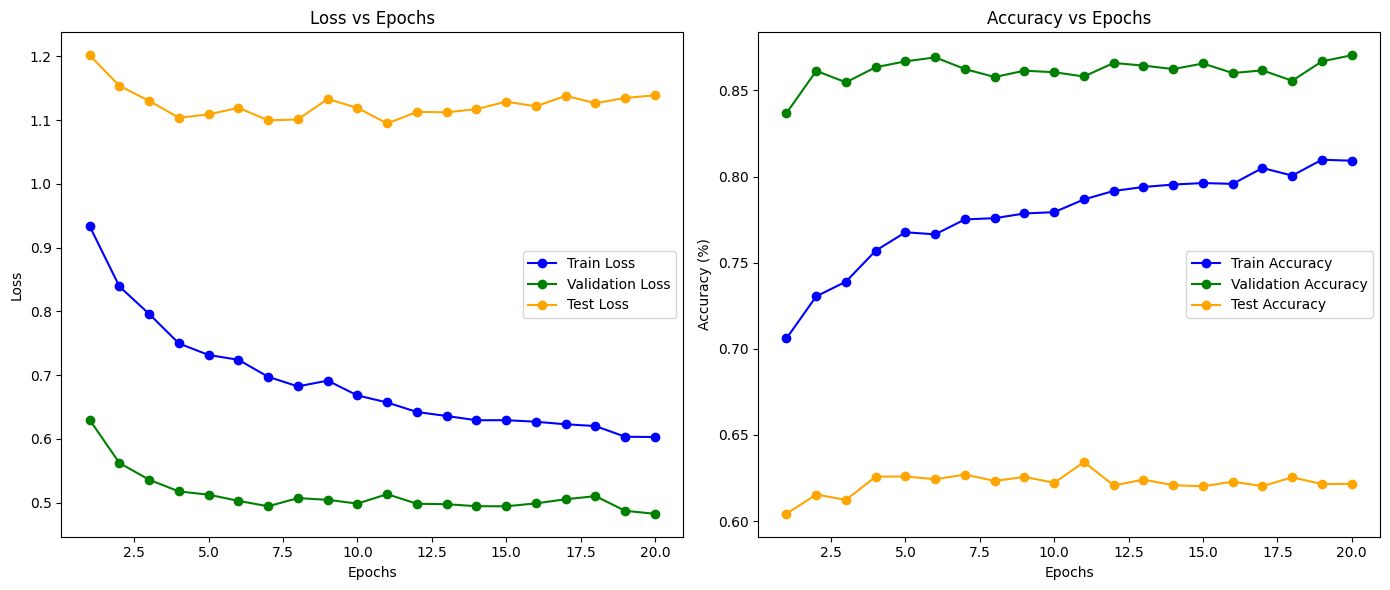

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_df_minmax.drop(columns=['label']).values  # Features from train_df
y_train = train_df_minmax['label'].values  # Labels from train_df

X_val = val_df_minmax.drop(columns=['label']).values  # Features from val_df
y_val = val_df_minmax['label'].values  # Labels from val_df

X_test = test_df_minmax.drop(columns=['label']).values  # Features from test_df
y_test = test_df_minmax['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df=train_df,
    test_df=test_df,
    num_layers=0,  # No hidden layers
    layers=[],  # Hidden layer size (not applicable here)
    loss_function="softmax",  # Use softmax for classification
    activation_func=[],  # No activation functions since no hidden layers
    batch_size=32,  # Mini-batch size
    learning_rate=0.001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")


# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)


## 1 hidden, relu

Training the MLP model with epochs...
Epoch 1/20 - Train Loss: 0.7919, Train Accuracy: 75.87%, Validation Loss: 0.5118, Validation Accuracy: 85.21%, Test Loss: 1.1489, Test Accuracy: 62.80%
Epoch 2/20 - Train Loss: 0.7166, Train Accuracy: 78.20%, Validation Loss: 0.4792, Validation Accuracy: 85.78%, Test Loss: 1.1325, Test Accuracy: 63.02%
Epoch 3/20 - Train Loss: 0.6710, Train Accuracy: 79.49%, Validation Loss: 0.4682, Validation Accuracy: 86.81%, Test Loss: 1.1246, Test Accuracy: 63.58%
Epoch 4/20 - Train Loss: 0.6404, Train Accuracy: 80.68%, Validation Loss: 0.4557, Validation Accuracy: 86.78%, Test Loss: 1.1367, Test Accuracy: 63.33%
Epoch 5/20 - Train Loss: 0.6175, Train Accuracy: 81.19%, Validation Loss: 0.4567, Validation Accuracy: 87.18%, Test Loss: 1.1262, Test Accuracy: 63.15%
Epoch 6/20 - Train Loss: 0.5982, Train Accuracy: 81.65%, Validation Loss: 0.4653, Validation Accuracy: 86.47%, Test Loss: 1.1358, Test Accuracy: 62.89%
Epoch 7/20 - Train Loss: 0.5848, Train Accuracy: 8

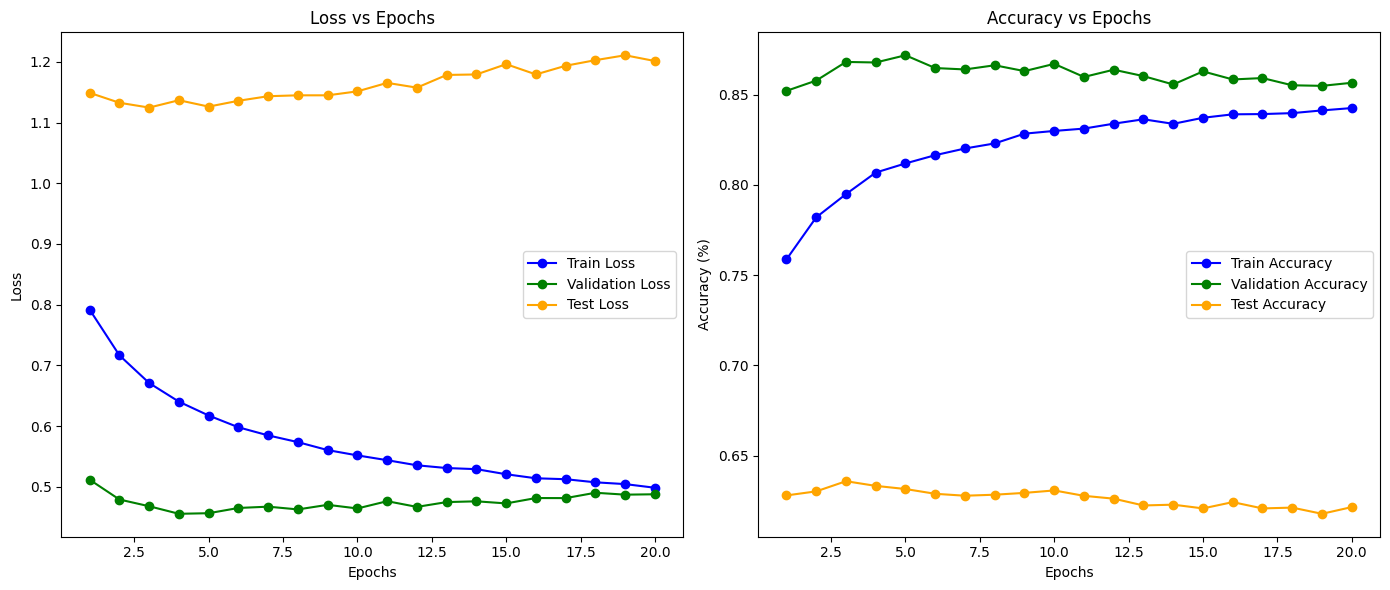

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_df.drop(columns=['label']).values  # Features from train_df
y_train = train_df['label'].values  # Labels from train_df

X_val = val_df.drop(columns=['label']).values  # Features from val_df
y_val = val_df['label'].values  # Labels from val_df

X_test = test_df.drop(columns=['label']).values  # Features from test_df
y_test = test_df['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df=train_df,
    test_df=test_df,
    num_layers=1,  # No hidden layers
    layers=[256],  # Hidden layer size (not applicable here)
    loss_function="softmax",  # Use softmax for classification
    activation_func=["relu"],  # No activation functions since no hidden layers
    batch_size=64,  # Mini-batch size
    learning_rate=0.001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")

# Optional: Split a portion of training data for validation
# val_split = 0.2
# val_size = int(val_split * X_train.shape[0])
# X_val, y_val = X_train[:val_size], y_train_onehot[:val_size]
# X_train, y_train_onehot = X_train[val_size:], y_train_onehot[val_size:]

# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# # Display epoch results
# print("\nEpoch-wise Performance:")
# for i, epoch in enumerate(epoch_array):
#     print(f"Epoch {epoch}: "
#           f"Train Loss = {train_losses[i]:.4f}, Train Accuracy = {train_accuracies[i] * 100:.2f}%, "
#           f"Val Loss = {val_losses[i]:.4f}, Val Accuracy = {val_accuracies[i] * 100:.2f}%, "
#           f"Test Loss = {test_losses[i]:.4f}, Test Accuracy = {test_accuracies[i] * 100:.2f}%")


plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

## 2 hidden layer, relu, 256 units

Training the MLP model with epochs...
Epoch 1/20 - Train Loss: 0.4947, Train Accuracy: 84.64%, Validation Loss: 0.3932, Validation Accuracy: 90.06%, Test Loss: 0.9020, Test Accuracy: 69.32%
Epoch 2/20 - Train Loss: 0.3207, Train Accuracy: 90.84%, Validation Loss: 0.3366, Validation Accuracy: 90.91%, Test Loss: 0.8614, Test Accuracy: 70.67%
Epoch 3/20 - Train Loss: 0.2270, Train Accuracy: 94.12%, Validation Loss: 0.3301, Validation Accuracy: 90.71%, Test Loss: 0.8518, Test Accuracy: 71.44%
Epoch 4/20 - Train Loss: 0.1725, Train Accuracy: 95.72%, Validation Loss: 0.3294, Validation Accuracy: 90.66%, Test Loss: 0.8653, Test Accuracy: 72.31%
Epoch 5/20 - Train Loss: 0.1341, Train Accuracy: 96.90%, Validation Loss: 0.3106, Validation Accuracy: 91.03%, Test Loss: 0.8779, Test Accuracy: 72.85%
Epoch 6/20 - Train Loss: 0.1052, Train Accuracy: 97.71%, Validation Loss: 0.3088, Validation Accuracy: 91.51%, Test Loss: 0.8910, Test Accuracy: 73.07%
Epoch 7/20 - Train Loss: 0.0868, Train Accuracy: 9

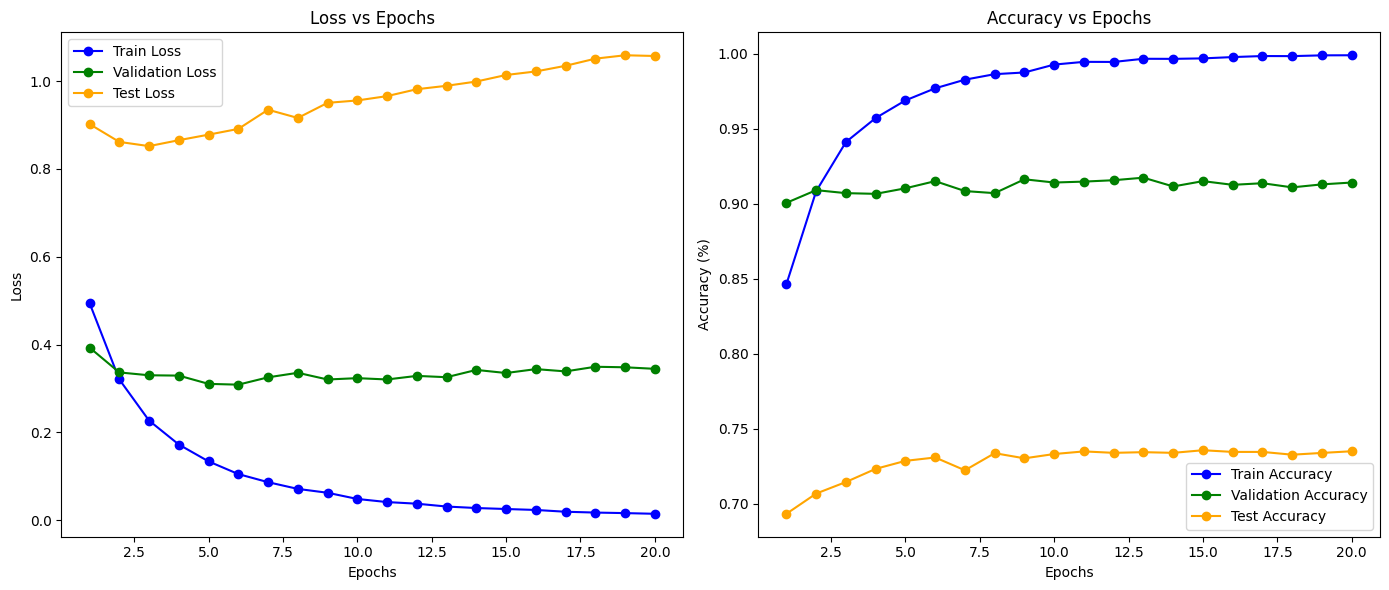

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_df.drop(columns=['label']).values  # Features from train_df
y_train = train_df['label'].values  # Labels from train_df

X_val = val_df.drop(columns=['label']).values  # Features from val_df
y_val = val_df['label'].values  # Labels from val_df

X_test = test_df.drop(columns=['label']).values  # Features from test_df
y_test = test_df['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df=train_df,
    test_df=test_df,
    num_layers=2,  # No hidden layers
    layers=[256, 256],  # Hidden layer size (not applicable here)
    loss_function="softmax",  # Use softmax for classification
    activation_func=["relu", "relu"],  # No activation functions since no hidden layers
    batch_size=32,  # Mini-batch size
    learning_rate=0.001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")


# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

## Tanh 2 layers

Training the MLP model with epochs...
Epoch 1/20 - Train Loss: 1.4807, Train Accuracy: 64.07%, Validation Loss: 1.3439, Validation Accuracy: 72.75%, Test Loss: 1.6288, Test Accuracy: 55.82%
Epoch 2/20 - Train Loss: 1.4147, Train Accuracy: 68.29%, Validation Loss: 1.2699, Validation Accuracy: 78.42%, Test Loss: 1.5990, Test Accuracy: 57.18%
Epoch 3/20 - Train Loss: 1.3602, Train Accuracy: 70.32%, Validation Loss: 1.2272, Validation Accuracy: 81.96%, Test Loss: 1.5449, Test Accuracy: 58.05%
Epoch 4/20 - Train Loss: 1.3008, Train Accuracy: 76.20%, Validation Loss: 1.1767, Validation Accuracy: 86.10%, Test Loss: 1.4914, Test Accuracy: 62.66%
Epoch 5/20 - Train Loss: 1.2995, Train Accuracy: 74.58%, Validation Loss: 1.1731, Validation Accuracy: 84.76%, Test Loss: 1.5179, Test Accuracy: 59.71%
Epoch 6/20 - Train Loss: 1.2643, Train Accuracy: 75.91%, Validation Loss: 1.1550, Validation Accuracy: 85.09%, Test Loss: 1.4851, Test Accuracy: 61.28%
Epoch 7/20 - Train Loss: 1.2504, Train Accuracy: 7

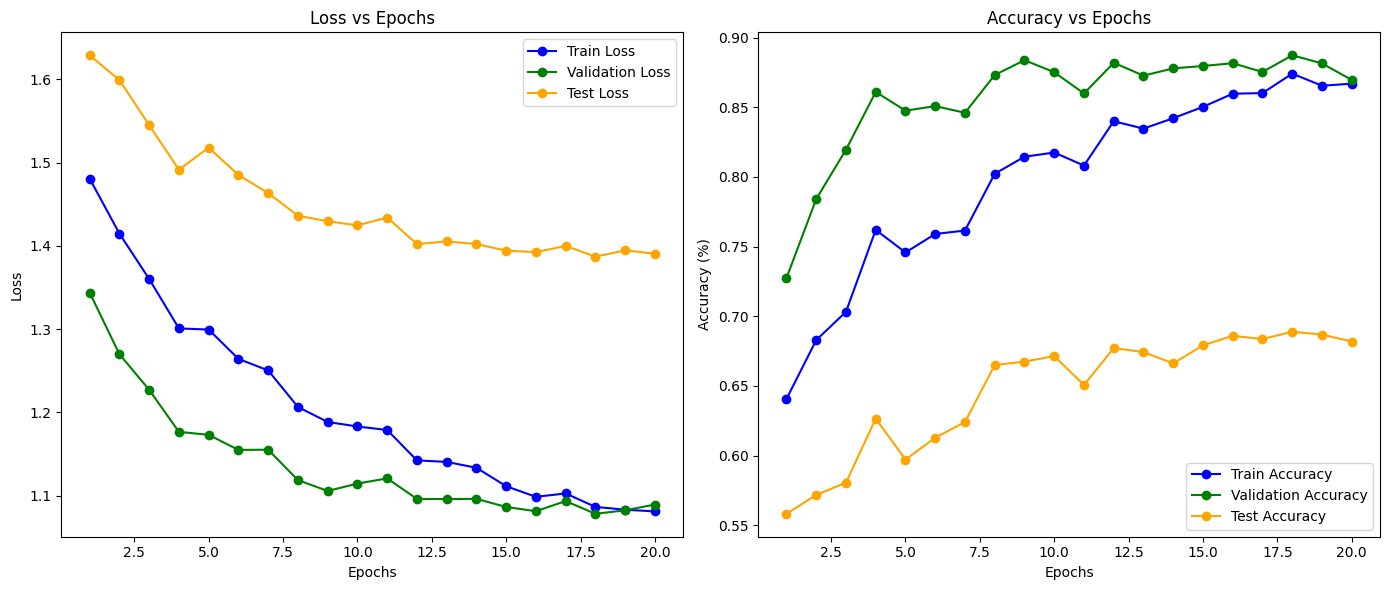

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_df_minmax.drop(columns=['label']).values  # Features from train_df
y_train = train_df_minmax['label'].values  # Labels from train_df

X_val = val_df_minmax.drop(columns=['label']).values  # Features from val_df
y_val = val_df_minmax['label'].values  # Labels from val_df

X_test = test_df_minmax.drop(columns=['label']).values  # Features from test_df
y_test = test_df_minmax['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df=train_df,
    test_df=test_df,
    num_layers=2,  # No hidden layers
    layers=[256, 256],  # Hidden layer size (not applicable here)
    loss_function="softmax",  # Use softmax for classification
    activation_func=["tanh", "tanh"],  # No activation functions since no hidden layers
    batch_size=32,  # Mini-batch size
    learning_rate=0.001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")


# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

## LeakyReLU 2 layers

Training the MLP model with epochs...
Epoch 1/20 - Train Loss: 0.5064, Train Accuracy: 85.21%, Validation Loss: 0.3883, Validation Accuracy: 90.42%, Test Loss: 0.9092, Test Accuracy: 69.54%
Epoch 2/20 - Train Loss: 0.3319, Train Accuracy: 90.80%, Validation Loss: 0.3531, Validation Accuracy: 90.71%, Test Loss: 0.8684, Test Accuracy: 71.27%
Epoch 3/20 - Train Loss: 0.2264, Train Accuracy: 93.98%, Validation Loss: 0.3298, Validation Accuracy: 91.71%, Test Loss: 0.8663, Test Accuracy: 71.77%
Epoch 4/20 - Train Loss: 0.1751, Train Accuracy: 95.63%, Validation Loss: 0.3168, Validation Accuracy: 91.76%, Test Loss: 0.8973, Test Accuracy: 71.79%
Epoch 5/20 - Train Loss: 0.1307, Train Accuracy: 96.90%, Validation Loss: 0.3286, Validation Accuracy: 91.22%, Test Loss: 0.8869, Test Accuracy: 72.60%
Epoch 6/20 - Train Loss: 0.1054, Train Accuracy: 97.73%, Validation Loss: 0.3291, Validation Accuracy: 91.37%, Test Loss: 0.9020, Test Accuracy: 72.85%
Epoch 7/20 - Train Loss: 0.0883, Train Accuracy: 9

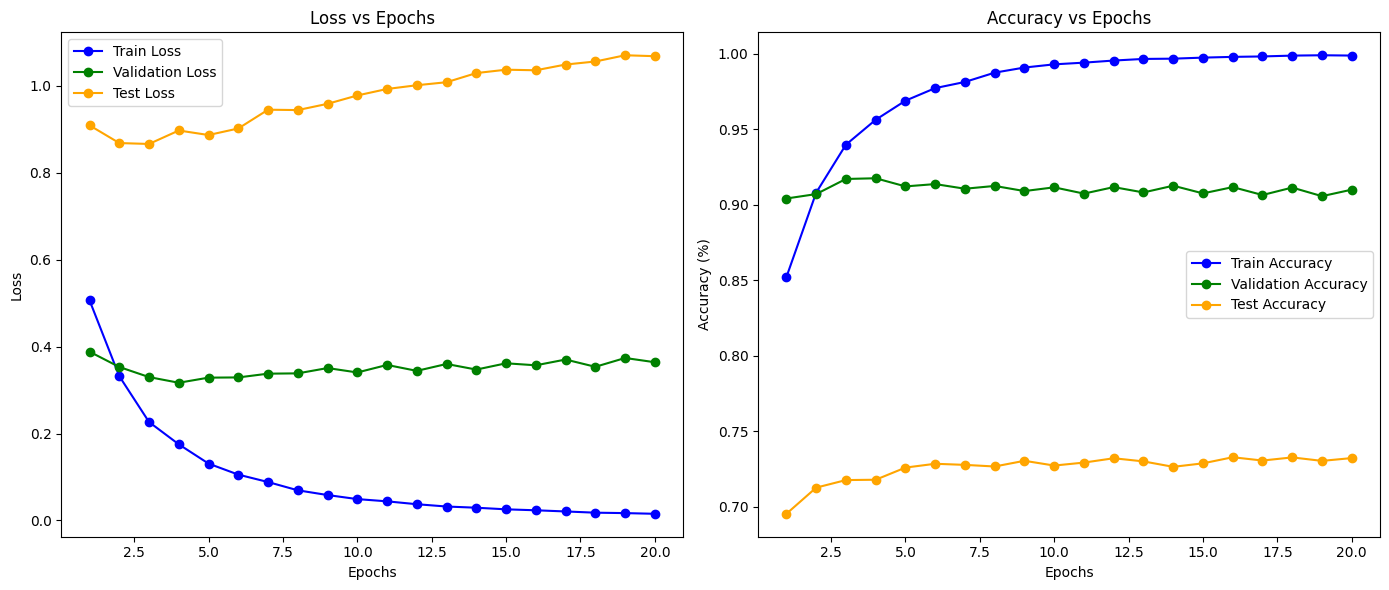

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_df.drop(columns=['label']).values  # Features from train_df
y_train = train_df['label'].values  # Labels from train_df

X_val = val_df.drop(columns=['label']).values  # Features from val_df
y_val = val_df['label'].values  # Labels from val_df

X_test = test_df.drop(columns=['label']).values  # Features from test_df
y_test = test_df['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df=train_df,
    test_df=test_df,
    num_layers=2,  # No hidden layers
    layers=[256, 256],  # Hidden layer size (not applicable here)
    loss_function="softmax",  # Use softmax for classification
    activation_func=["leakyrelu", "leakyrelu"],  # No activation functions since no hidden layers
    batch_size=32,  # Mini-batch size
    learning_rate=0.001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")


# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

## Relu with L1 activation

Training the MLP model with epochs...
Epoch 1/20 - Train Loss: 0.3658, Train Accuracy: 89.21%, Validation Loss: 0.3702, Validation Accuracy: 89.77%, Test Loss: 0.8873, Test Accuracy: 70.67%
Epoch 2/20 - Train Loss: 0.2228, Train Accuracy: 93.69%, Validation Loss: 0.3703, Validation Accuracy: 89.46%, Test Loss: 0.9014, Test Accuracy: 71.86%
Epoch 3/20 - Train Loss: 0.1371, Train Accuracy: 96.58%, Validation Loss: 0.3506, Validation Accuracy: 90.36%, Test Loss: 0.9147, Test Accuracy: 72.83%
Epoch 4/20 - Train Loss: 0.1118, Train Accuracy: 97.31%, Validation Loss: 0.3694, Validation Accuracy: 90.14%, Test Loss: 0.9388, Test Accuracy: 72.78%
Epoch 5/20 - Train Loss: 0.0772, Train Accuracy: 98.35%, Validation Loss: 0.3871, Validation Accuracy: 89.65%, Test Loss: 0.9615, Test Accuracy: 73.43%
Epoch 6/20 - Train Loss: 0.0647, Train Accuracy: 98.74%, Validation Loss: 0.3763, Validation Accuracy: 90.40%, Test Loss: 0.9976, Test Accuracy: 72.61%
Epoch 7/20 - Train Loss: 0.0488, Train Accuracy: 9

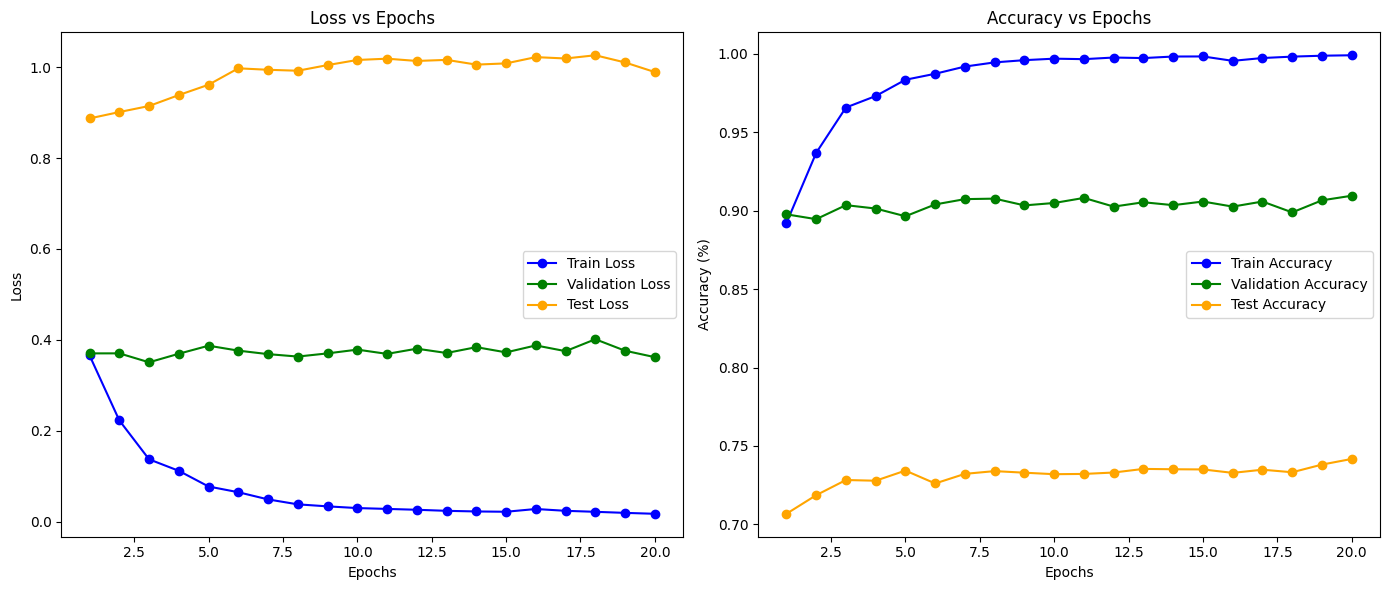

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_df_zscore.drop(columns=['label']).values  # Features from train_df
y_train = train_df_zscore['label'].values  # Labels from train_df

X_val = val_df_zscore.drop(columns=['label']).values  # Features from val_df
y_val = val_df_zscore['label'].values  # Labels from val_df

X_test = test_df_zscore.drop(columns=['label']).values  # Features from test_df
y_test = test_df_zscore['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df=train_df,
    test_df=test_df,
    num_layers=2,  # No hidden layers
    layers=[256, 256],  # Hidden layer size (not applicable here)
    loss_function="softmax",  # Use softmax for classification
    activation_func=["relu", "relu"],  # No activation functions since no hidden layers
    batch_size=32,  # Mini-batch size
    learning_rate=0.001,  # Learning rate
    L1_reg=0.0015,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")


# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

## L2 reg, relu

Training the MLP model with epochs...
Epoch 1/20 - Train Loss: 0.4131, Train Accuracy: 88.45%, Validation Loss: 0.3950, Validation Accuracy: 89.49%, Test Loss: 0.8822, Test Accuracy: 70.51%
Epoch 2/20 - Train Loss: 0.2617, Train Accuracy: 93.43%, Validation Loss: 0.3623, Validation Accuracy: 89.91%, Test Loss: 0.8444, Test Accuracy: 71.77%
Epoch 3/20 - Train Loss: 0.1971, Train Accuracy: 95.86%, Validation Loss: 0.3444, Validation Accuracy: 90.26%, Test Loss: 0.8153, Test Accuracy: 73.57%
Epoch 4/20 - Train Loss: 0.1733, Train Accuracy: 96.54%, Validation Loss: 0.3466, Validation Accuracy: 90.40%, Test Loss: 0.8137, Test Accuracy: 73.19%
Epoch 5/20 - Train Loss: 0.1605, Train Accuracy: 96.99%, Validation Loss: 0.3180, Validation Accuracy: 91.50%, Test Loss: 0.8340, Test Accuracy: 72.99%
Epoch 6/20 - Train Loss: 0.1476, Train Accuracy: 97.23%, Validation Loss: 0.3074, Validation Accuracy: 91.60%, Test Loss: 0.8024, Test Accuracy: 73.95%
Epoch 7/20 - Train Loss: 0.1377, Train Accuracy: 9

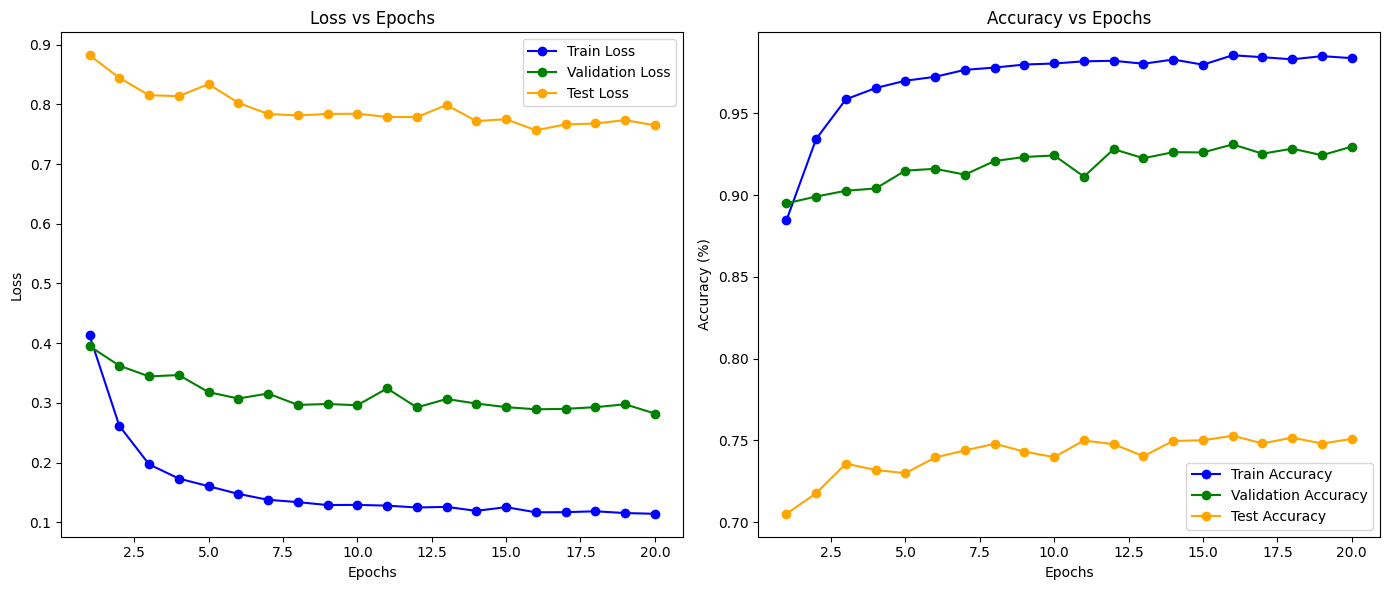

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_df_zscore.drop(columns=['label']).values  # Features from train_df
y_train = train_df_zscore['label'].values  # Labels from train_df

X_val = val_df_zscore.drop(columns=['label']).values  # Features from val_df
y_val = val_df_zscore['label'].values  # Labels from val_df

X_test = test_df_zscore.drop(columns=['label']).values  # Features from test_df
y_test = test_df_zscore['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df=train_df,
    test_df=test_df,
    num_layers=2,  # No hidden layers
    layers=[256, 256],  # Hidden layer size (not applicable here)
    loss_function="softmax",  # Use softmax for classification
    activation_func=["relu", "relu"],  # No activation functions since no hidden layers
    batch_size=32,  # Mini-batch size
    learning_rate=0.001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.1,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")


# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

## Importing unnormalized data and converting it to a dataframe

In [ ]:
import medmnist
from torchvision import transforms
import torch.utils.data as data
from torch.nn.functional import one_hot

data_flag = 'organamnist'  # set the name of the dataset to download
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Parameters
BATCH_SIZE = 128

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 matrix to a 784-dimensional vector
])

# apply one-hot encoding to labels
class OneHotEncodedDataset(DataClass):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        label = one_hot(torch.tensor(label), num_classes=n_classes).float()  # One-hot encode the label
        return image, label

# load the data with one-hot encoded labels
train_dataset = OneHotEncodedDataset(split='train', transform=data_transform, download=download)
test_dataset = OneHotEncodedDataset(split='test', transform=data_transform, download=download)
val_dataset = OneHotEncodedDataset(split="val", transform=data_transform, download=download)


# Get dataloader
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 38.2M/38.2M [00:01<00:00, 20.0MB/s]


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz


In [ ]:
import pandas as pd

def dataset_to_dataframe(data_loader):
    # Store images and labels
    data = []
    labels = []

    # Loop through the dataset
    for images, lbls in data_loader:
        # Flatten each image and add it to the data list
        for img, lbl in zip(images, lbls):
            data.append(img.numpy())           # Convert image tensor to numpy array
            labels.append(lbl.argmax().item())  # Convert one-hot encoded label to class index

    # Convert lists to DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels  # Add labels as the last column

    # Print the first few rows and the total number of data points
    # print("First few rows of the DataFrame:")
    # print(df.head())
    # print("===================")
    # print("Number of data points:", len(df))

    return df

# Making the dataframes with size 28
train_df = dataset_to_dataframe(train_loader)
val_df = dataset_to_dataframe(val_loader)
test_df = dataset_to_dataframe(test_loader)


## 2 hidden relu layers with 256 units on unnormalized data

Training the MLP model with epochs...
Epoch 1/20 - Train Loss: 2.3258, Train Accuracy: 21.01%, Validation Loss: 2.2902, Validation Accuracy: 27.15%, Test Loss: 2.3499, Test Accuracy: 16.55%
Epoch 2/20 - Train Loss: 2.2637, Train Accuracy: 24.74%, Validation Loss: 2.2053, Validation Accuracy: 29.81%, Test Loss: 2.3033, Test Accuracy: 20.76%
Epoch 3/20 - Train Loss: 2.1672, Train Accuracy: 32.93%, Validation Loss: 2.0734, Validation Accuracy: 43.77%, Test Loss: 2.2249, Test Accuracy: 28.41%
Epoch 4/20 - Train Loss: 2.0212, Train Accuracy: 35.78%, Validation Loss: 1.9041, Validation Accuracy: 41.13%, Test Loss: 2.1014, Test Accuracy: 32.19%
Epoch 5/20 - Train Loss: 1.9175, Train Accuracy: 42.02%, Validation Loss: 1.7732, Validation Accuracy: 48.37%, Test Loss: 2.0171, Test Accuracy: 37.23%
Epoch 6/20 - Train Loss: 1.8024, Train Accuracy: 46.84%, Validation Loss: 1.6368, Validation Accuracy: 54.06%, Test Loss: 1.9206, Test Accuracy: 41.35%
Epoch 7/20 - Train Loss: 1.7273, Train Accuracy: 4

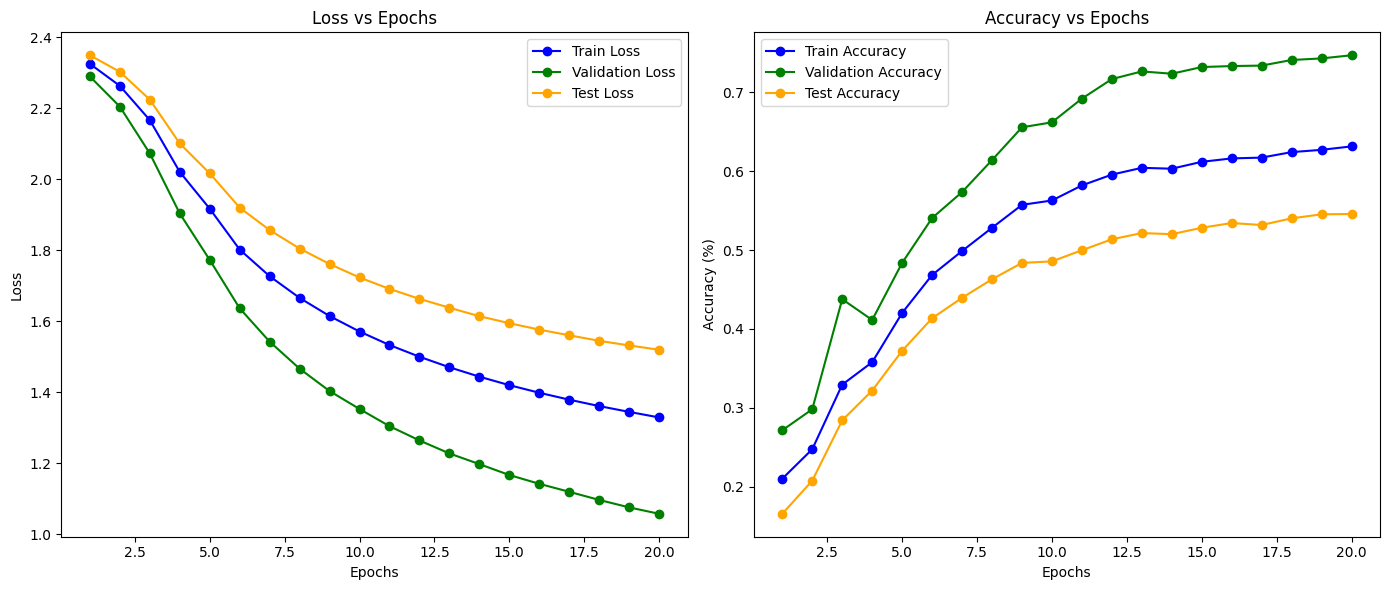

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_df.drop(columns=['label']).values  # Features from train_df
y_train = train_df['label'].values  # Labels from train_df

X_val = val_df.drop(columns=['label']).values  # Features from val_df
y_val = val_df['label'].values  # Labels from val_df

X_test = test_df.drop(columns=['label']).values  # Features from test_df
y_test = test_df['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df=X_train,
    test_df=test_df,
    num_layers=2,  # No hidden layers
    layers=[256, 256],  # Hidden layer size (not applicable here)
    loss_function="softmax",  # Use softmax for classification
    activation_func=["relu", "relu"],  # No activation functions since no hidden layers
    batch_size=32,  # Mini-batch size
    learning_rate=0.00001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")


# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

## MLP class for Size 128 images

In [ ]:
class MLP():
    def __init__(self, train_df, test_df, num_layers=2, layers=[64, 64], loss_function="softmax",
                 activation_func=["sigmoid", "relu"], batch_size=50, learning_rate=0.1, L1_reg = 0.0, L2_reg = 0.0,
                 max_iters=1000, epsilon=0.001):
        # self.train_df = train_df
        # self.test_df = test_df
        self.num_layers = num_layers
        self.layers = layers
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.output_size = 11
        self.max_iters = max_iters
        self.epsilon = epsilon

        if L1_reg > 0.0 and L2_reg > 0.0:
            raise Exception("Only regularize on L1 or L2, not both. Set one of the terms to 0")

        self.L1_reg = L1_reg
        self.L2_reg = L2_reg

        # Check if the number of activations matches the number of layers
        if len(activation_func) != num_layers:
            raise Exception("The number of activation functions must match the number of layers.")

        # Check to see if we have the no hidden layer case
        if num_layers == 0 and len(activation_func) == 0 and len(layers) == 0:
            activation_func = ["identity"]

        # Dictionary to map activation function names to their implementations
        activation_map = {
            "relu": ReLULayer,
            "leakyrelu": LeakyReLULayer,
            "sigmoid": SigmoidLayer,
            "tanh": TanhLayer,
            "identity": IdentityLayer
        }

        # Create an array of activation layers in the specified order
        self.activation_arr = []
        for i in range(len(activation_func)):
            if activation_func[i] in activation_map:
                layer_input_size = layers[i - 1] if i > 0 else train_df.shape[1] #- 1 # Input size of this layer
                if i < num_layers - 1:
                    layer_output_size = layers[i]  # Output size of this layer
                else:
                    layer_output_size = self.output_size # Output size of the last layer is fixed to the number of classes
                self.activation_arr.append(activation_map[activation_func[i]](layer_input_size, layer_output_size, self.learning_rate, self.L1_reg, self.L2_reg))
            else:
                raise ValueError(f"Unsupported activation function: {activation_func[i]}")

        # Initialize the loss function
        if loss_function == "softmax":
            self.loss_layer = SoftmaxLayer(self.output_size, self.output_size)
            self.loss_fn = CategoricalCrossEntropy()
        else:
            raise ValueError(f"Unsupported loss function: {loss_function}")

    def softmax(self, x):
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_shifted)
        exp_sum = np.sum(exp_x, axis=1, keepdims=True)
        softmax_output = exp_x / exp_sum
        return softmax_output

    def forward(self, x, is_train=True):
        """
        Perform forward propagation through all layers.
        """
        for layer in self.activation_arr:
            x = layer.forward(x, is_train)
        # return x
        return self.softmax(x)

    def backward(self, predictions, labels):
        """
        Perform backpropagation through all layers.
        """
        loss_grad = self.loss_fn.backward(predictions, labels)  # Loss gradient
        # should do backward on softmax too
        for layer in reversed(self.activation_arr):
            loss_grad = layer.backward(loss_grad)
        return loss_grad # partial L / partial X, grad w.r.t. input data

    def fit(self, X, y, X_val=None, y_val=None, y_test=None, y_val_onehot = None, y_test_onehot=None, X_test=None, epochs=10):
        """
        Train the model with mini-batch gradient descent for a specified number of epochs.

        Parameters:
        - X: Training features.
        - y: One-hot encoded training labels.
        - X_val: Validation features (optional).
        - y_val: Validation labels (optional).
        - y_test: Test labels (optional).
        - y_test_onehot: One-hot encoded test labels (optional).
        - epochs: Number of epochs to train.

        Returns:
        - epoch_array: Array of epoch numbers.
        - train_losses: Array of training losses for each epoch.
        - val_losses: Array of validation losses for each epoch (if validation data is provided).
        - test_losses: Array of test losses for each epoch (if test data is provided).
        - train_accuracies: Array of training accuracies for each epoch.
        - val_accuracies: Array of validation accuracies for each epoch (if validation data is provided).
        - test_accuracies: Array of test accuracies for each epoch (if test data is provided).
        """
        N = X.shape[0]

        # Initialize arrays to store results
        epoch_array = []
        train_losses = []
        val_losses = []
        test_losses = []
        train_accuracies = []
        val_accuracies = []
        test_accuracies = []

        for epoch in range(epochs):
            print("Running Epoch ", epoch)
            # Shuffle the training data at the start of each epoch
            indices = np.arange(N)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # Mini-batch gradient descent
            for start in range(0, N, self.batch_size):
                end = start + self.batch_size
                batch_X = X[start:end]
                batch_y = y[start:end]

                # Forward and backward pass
                yhat = self.forward(batch_X)
                self.backward(yhat, batch_y)

            # Calculate train loss and accuracy
            train_predictions = self.forward(X)
            base_loss = -np.sum(y * np.log(train_predictions + self.epsilon)) / y.shape[0]
            train_loss = base_loss
            if self.L1_reg > 0:
                l1_loss = self.L1_reg * sum(np.sum(np.abs(layer.weights)) for layer in self.activation_arr if hasattr(layer, 'weights'))
                train_loss += l1_loss
            if self.L2_reg > 0:
                l2_loss = self.L2_reg * sum(np.sum(layer.weights ** 2) for layer in self.activation_arr if hasattr(layer, 'weights'))
                train_loss += l2_loss
            train_accuracy = self.eval_acc(np.argmax(y, axis=1), train_predictions)

            # Append train results
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validation loss and accuracy
            if X_val is not None and y_val is not None:
                val_predictions = self.forward(X_val)
                val_loss = -np.sum(y_val_onehot * np.log(val_predictions + self.epsilon)) / y_val_onehot.shape[0]
                if self.L1_reg > 0:
                    val_loss += l1_loss
                if self.L2_reg > 0:
                    val_loss += l2_loss
                val_accuracy = self.eval_acc(y_val, val_predictions)

                # Append validation results
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)
            else:
                val_losses.append(None)
                val_accuracies.append(None)
            # Test loss and accuracy
            if y_test_onehot is not None:
                test_predictions = self.forward(X_test)
                test_loss = -np.sum(y_test_onehot * np.log(test_predictions + self.epsilon)) / y_test_onehot.shape[0]
                if self.L1_reg > 0:
                    test_loss += l1_loss
                if self.L2_reg > 0:
                    test_loss += l2_loss
                test_accuracy = self.eval_acc(y_test, test_predictions)

                # Append test results
                test_losses.append(test_loss)
                test_accuracies.append(test_accuracy)
            else:
                test_losses.append(None)
                test_accuracies.append(None)

            # Store epoch
            epoch_array.append(epoch + 1)

            # Print progress
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%", end="")
            if X_val is not None:
                print(f", Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%", end="")
            if y_test_onehot is not None:
                print(f", Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%", end="")
            print()

        return epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

    def predict(self, X):
      return self.forward(X)

    def eval_acc(self, y, haty):
        if len(haty.shape) > 1:
            predicted_labels = np.argmax(haty, axis=1)
        else:
            predicted_labels = haty

        accuracy = np.mean(predicted_labels == y)
        return accuracy

## ReLU with 2 layers of 256 units

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_data_size128.drop(columns=['label']).values  # Features from train_df
y_train = train_data_size128['label'].values  # Labels from train_df

X_val = val_data_size128.drop(columns=['label']).values  # Features from val_df
y_val = val_data_size128['label'].values  # Labels from val_df

X_test = test_data_size128.drop(columns=['label']).values  # Features from test_df
y_test = test_data_size128['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df= X_train,
    test_df=None,
    num_layers=2,
    layers=[256, 256],  # Hidden layer sizes
    loss_function="softmax",  # Use softmax for classification
    activation_func=["leakyrelu", "leakyrelu"],
    batch_size=32,  # Mini-batch size
    learning_rate=0.00001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")

# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, X_test, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

Training the MLP model with epochs...


## ReLU with 2 layers of 256 units, L1 regularization

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_data_size128.drop(columns=['label']).values  # Features from train_df
y_train = train_data_size128['label'].values  # Labels from train_df

X_val = val_data_size128.drop(columns=['label']).values  # Features from val_df
y_val = val_data_size128['label'].values  # Labels from val_df

X_test = test_data_size128.drop(columns=['label']).values  # Features from test_df
y_test = test_data_size128['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df= X_train,
    test_df=None,
    num_layers=2,
    layers=[256, 256],  # Hidden layer sizes
    loss_function="softmax",  # Use softmax for classification
    activation_func=["leakyrelu", "leakyrelu"],
    batch_size=32,  # Mini-batch size
    learning_rate=0.00001,  # Learning rate
    L1_reg=0.01,   # The lambda term for L1 regularization
    L2_reg=0.0,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")

# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, X_test, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

## ReLU with 2 layers of 256 units, L1 regularization

In [ ]:
import numpy as np

# Split train_df and test_df into features (X) and labels (y)
X_train = train_data_size128.drop(columns=['label']).values  # Features from train_df
y_train = train_data_size128['label'].values  # Labels from train_df

X_val = val_data_size128.drop(columns=['label']).values  # Features from val_df
y_val = val_data_size128['label'].values  # Labels from val_df

X_test = test_data_size128.drop(columns=['label']).values  # Features from test_df
y_test = test_data_size128['label'].values  # Labels from test_df

# Convert y_train and y_test to one-hot encoded labels for the MLP
num_classes = 11  # Determine the number of classes
y_train_onehot = np.eye(num_classes)[y_train]  # One-hot encode train labels
y_val_onehot = np.eye(num_classes)[y_val]  # One-hot encode test labels
y_test_onehot = np.eye(num_classes)[y_test]  # One-hot encode test labels

# Initialize the MLP model
mlp = MLP(
    train_df= X_train,
    test_df=None,
    num_layers=2,
    layers=[256, 256],  # Hidden layer sizes
    loss_function="softmax",  # Use softmax for classification
    activation_func=["leakyrelu", "leakyrelu"],
    batch_size=32,  # Mini-batch size
    learning_rate=0.00001,  # Learning rate
    L1_reg=0.0,   # The lambda term for L1 regularization
    L2_reg=0.1,   # The lambda term for L2 regularization
    max_iters=5000,  # Maximum iterations for training
    epsilon=0.0001  # Convergence threshold
)

# Training the MLP model with epochs and evaluate performance
print("Training the MLP model with epochs...")

# Train the model and retrieve epoch data
epoch_array, train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = mlp.fit(
    X_train, y_train_onehot, X_val, y_val, y_test, y_val_onehot, y_test_onehot, X_test, epochs=20
)

# Evaluate final performance
print("\nFinal Evaluation:")

# Training performance
yhat_train = mlp.predict(X_train)
train_accuracy = mlp.eval_acc(np.argmax(y_train_onehot, axis=1), yhat_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Test performance
yhat_test = mlp.predict(X_test)
test_accuracy = mlp.eval_acc(y_test, yhat_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



plotting_stuff(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies)

# CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from medmnist import INFO
from medmnist.dataset import OrganAMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import onnx
import torch.nn.functional as F

##################################
########### PARAMETERS ###########
##################################
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
MAX_EPOCHS = 40
IMSIZE = 128
##################################
##################################
##################################
device = torch.device("mps")
#device = torch.device("cpu")
data_flag = "organamnist"
info = INFO[data_flag]
n_classes = len(info["label"])

# Load dataset
transform = Compose([ToTensor(), Normalize(mean=[.5], std=[.5])])

train_data_size128 = OrganAMNIST(split="train", transform=transform, download=True, size=IMSIZE)
val_data_size128 = OrganAMNIST(split="val", transform=transform, download=True, size=IMSIZE)
test_data_size128 = OrganAMNIST(split="test", transform=transform, download=True, size=IMSIZE)

train_loader = DataLoader(train_data_size128, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data_size128, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data_size128, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Define CNN
class CNN(nn.Module):
    def __init__(self, n_classes, image_size, kernel_size=3, stride=1, padding=1, pool=2):
        # This method initializes the layers and activation functions used in the network
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch4 = nn.BatchNorm2d(256)

        # Maximum pooling (reduce image size by a factor of 2)
        self.pool = nn.MaxPool2d(kernel_size=pool, stride=pool)
        # fully connected layer 1:
        #self.fc1 = nn.Linear(int(conv2 * (image_size/4)**2), fc1) # at this point, the images will have been pooled twice, so size goes from 28x28 to 7x7
        self.fc1 = nn.Linear(int(256 * (image_size/16)**2), 512)

        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # This method uses the objects initialized above to compute the forward pass
        x = self.pool(self.relu(self.batch1(self.conv1(x))))
        x = self.pool(self.relu(self.batch2(self.conv2(x))))
        x = self.pool(self.relu(self.batch3(self.conv3(x))))
        x = self.pool(self.relu(self.batch4(self.conv4(x))))

        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # convert image matrix to vector
        x = self.relu(self.fc1(x))
        #x = self.fc2(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

# Instantiate model
#model = CNN(n_classes, IMSIZE).to(device)
model = CNN(n_classes, IMSIZE, kernel_size=3, stride=1, pool=2).to(device)

# define loss (the PyTorch Categorical Cross Entropy loss)
criterion = nn.CrossEntropyLoss()
# define the optimizer, which computes the weight updates, we choose Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

torch_input = torch.randn(1, 1, 128, 128).to(device)
#onnx_program = torch.onnx.dynamo_export(model, torch_input)
onnx_program = torch.onnx.export(model, torch_input, "model.onnx", opset_version=17)
#onnx_program.save("my_image_classifier2.onnx")

def train(model, loader, optimizer, criterion, device, epoch):
    model.train()
    total_loss, total_correct = 0, 0
    minibatch_losses = []  # To store loss for each minibatch

    for inputs, targets in loader:
        targets = targets.squeeze(dim=1)  # Remove unnecessary dimensions
        inputs, targets = inputs.to(device), targets.to(device)

        # set all gradients to zero at the start of each minibatch, see https://stackoverflow.com/a/48009142
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs, targets)
        # Backpropagation and weight update
        loss.backward()
        optimizer.step()

        # Update loss and accuracy
        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == targets).sum().item()
        # Store minibatch loss
        minibatch_losses.append(loss.item())

    # Compute average loss and accuracy for the epoch
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / len(loader.dataset)

    return avg_loss, accuracy, minibatch_losses

# Evaluation loop
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad(): # don't accumulate gradients for evaluation
        for inputs, targets in loader:
            targets = targets.squeeze(dim=1)  # Remove unnecessary dimensions
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            # boolean array indicating if the index of the max entry of the output vector corresponds to the target
            correct_predictions = (outputs.argmax(dim=1) == targets)
            # count the correct predictions and add up
            total_correct += correct_predictions.sum().item()
    # len(loader) is the number of minibatches
    # len(loader.dataset) is the number of instances
    return total_loss / len(loader), total_correct / len(loader.dataset)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
test_losses, test_accuracies = [], []
all_train_losses = []

for epoch in range(MAX_EPOCHS):
    train_loss, train_acc, losses = train(model, train_loader, optimizer, criterion, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # Store metrics
    all_train_losses += losses
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

# Test performance
# test_loss, test_acc = evaluate(model, test_loader, criterion, device)
# print(f"Test Accuracy: {test_acc:.4f}")
################################
########### PLOTTING ###########
################################

epochs = range(1, len(train_losses) + 1)

# Identify the epoch with the highest validation accuracy
best_test_acc = max(test_accuracies)
best_epoch = test_accuracies.index(best_test_acc) + 1  # Index is 0-based, epochs are 1-based

output_dir = "plots"
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Plot train, validation, and test losses and accuracies
plot_path = os.path.join(output_dir, f"train-val-loss_{BATCH_SIZE}_{LEARNING_RATE}_{MAX_EPOCHS}_{IMSIZE}.png")
plt.figure(figsize=(12, 5))

# Loss vs. Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, test_losses, label="Test Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

# Accuracy vs. Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o')

# Highlight the epoch with the highest validation accuracy
plt.scatter(best_epoch, best_test_acc, color='red', label=f"Best Test Acc (Epoch {best_epoch})", zorder=5)
plt.text(best_epoch, best_test_acc, f"{best_test_acc:.4f}", color='red', fontsize=10, ha='center', va='bottom')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()

plt.tight_layout()
plt.savefig(plot_path, format="png")
plt.close()

# Pretrained ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from medmnist import INFO
from medmnist.dataset import OrganAMNIST
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights
from torchvision.transforms import Compose, Lambda
import os
import onnx

##################################
########### PARAMETERS ###########
##################################
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
MAX_EPOCHS = 40
IMSIZE = 128
PATIENCE = 10
##################################
##################################
##################################
device = torch.device("mps")
#device = torch.device("cpu")
info = INFO["organamnist"]
n_classes = len(info["label"])

# Dataset transforms
# OrganAMNIST images are grayscale, but ResNet takes RGB, so convert to 3 channels
transform = Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

weights = ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)
#transform = weights.transforms()

train_data_size128 = OrganAMNIST(split='train', transform=transform, download=True, size=IMSIZE)
test_data_size128 = OrganAMNIST(split='test', transform=transform, download=True, size=IMSIZE)
val_data_size128 = OrganAMNIST(split='val', transform=transform, download=True, size=IMSIZE)

train_loader = DataLoader(train_data_size128, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data_size128, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data_size128, batch_size=BATCH_SIZE, shuffle=False)

# Freeze all convolutional layers
for param in model.parameters():
    param.requires_grad = False
# Replace the fully connected layers
num_classes = len(info['label'])  # Get the number of classes in OrganAMNIST

# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(128, num_classes),
#     #nn.Softmax(dim=num_classes)
# )
# print(model)

# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 1024),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
#     nn.Linear(1024, 512),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
#     nn.Linear(512, num_classes),
#     nn.Softmax(dim=1)
# )

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(inplace=True),
    nn.Softmax(dim=1)
)
print(model)

model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)  # Train only fully connected layers

# torch_input = torch.randn(1, 3, 224, 224).to(device)
# onnx_program = torch.onnx.dynamo_export(model, torch_input)
# onnx_program.save("resnet.onnx")

# Training function
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0, 0
    minibatch_losses = []  # To store loss for each minibatch

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.squeeze(dim=1)  # Remove unnecessary dimensions

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == targets).sum().item()
        minibatch_losses.append(loss.item())

    return total_loss / len(loader), total_correct / len(loader.dataset), minibatch_losses

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.squeeze(dim=1)  # Remove unnecessary dimensions

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()

    return total_loss / len(loader), total_correct / len(loader.dataset)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
test_losses, test_accuracies = [], []
all_train_losses = []

# Training loop
best_val_loss = float('inf')
patience_counter = 0

# Training loop with early stopping
for epoch in range(MAX_EPOCHS):
    train_loss, train_acc, losses = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # Store metrics
    all_train_losses += losses
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

    # Check for early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0
        best_model_state = model.state_dict()  # Save the best model state
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Load the best model state after early stopping
model.load_state_dict(best_model_state)

################################
########### PLOTTING ###########
################################
epochs = range(1, len(train_losses) + 1)

# Identify the epoch with the highest validation accuracy
best_test_acc = max(test_accuracies)
best_epoch = test_accuracies.index(best_test_acc) + 1  # Index is 0-based, epochs are 1-based

output_dir = "plots"
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Plot train, validation, and test losses and accuracies
plot_path = os.path.join(output_dir, f"RESNET-train-val-loss_{BATCH_SIZE}_{LEARNING_RATE}_{MAX_EPOCHS}_{IMSIZE}.png")
plt.figure(figsize=(12, 5))

# Loss vs. Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, test_losses, label="Test Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

# Accuracy vs. Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o')

# Highlight the epoch with the highest validation accuracy
plt.scatter(best_epoch, best_test_acc, color='red', label=f"Best Test Acc (Epoch {best_epoch})", zorder=5)
plt.text(best_epoch, best_test_acc, f"{best_test_acc:.4f}", color='red', fontsize=10, ha='center', va='bottom')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()

plt.tight_layout()
plt.savefig(plot_path, format="png")
plt.close()